# 01 - Setup MLflow + YOLO12
## Instalación y configuración inicial del ambiente

In [1]:
# Instalación de dependencias
!pip install ultralytics==8.3.0  # YOLO12 está en ultralytics 8.3+
!pip install mlflow==2.11.0
!pip install opencv-python-headless
!pip install matplotlib seaborn
!pip install pandas numpy
!pip install pillow

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.3/881.3 KB 1.5 MB/s eta 0:00:001.2 MB/s eta 0:00:01
  Using cached ultralytics_thop-2.0.18-py3-none-any.whl (28 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 33.2 MB/s eta 0:00:00m eta 0:00:010:01:01
  Using cached opencv_python-4.13.0.90-cp37-abi3-manylinux_2_28_x86_64.whl (72.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 28.0 MB/s eta 0:00:00m eta 0:00:010:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.12.0.88
    Uninstalling opencv-python-4.12.0.88:
      Successfully uninstalled opencv-python-4.12.0.88
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/1

In [4]:
import mlflow
import mlflow.pytorch
from ultralytics import YOLO
import os
from pathlib import Path

## Configuración de MLflow

In [5]:
# Crear estructura de carpetas
BASE_DIR = Path("./product_recognition")
MLFLOW_DIR = BASE_DIR / "mlruns"
DATASETS_DIR = BASE_DIR / "datasets"
MODELS_DIR = BASE_DIR / "models"
ARTIFACTS_DIR = BASE_DIR / "artifacts"

for dir_path in [MLFLOW_DIR, DATASETS_DIR, MODELS_DIR, ARTIFACTS_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)
    print(f"✓ Created: {dir_path}")

✓ Created: product_recognition/mlruns
✓ Created: product_recognition/datasets
✓ Created: product_recognition/models
✓ Created: product_recognition/artifacts


In [6]:
# Configurar MLflow tracking URI
mlflow.set_tracking_uri(f"file:///{MLFLOW_DIR.absolute()}")
print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")

# Crear experimento
EXPERIMENT_NAME = "product_recognition_yolo12"
try:
    experiment_id = mlflow.create_experiment(
        EXPERIMENT_NAME,
        artifact_location=str(ARTIFACTS_DIR.absolute())
    )
    print(f"✓ Created experiment: {EXPERIMENT_NAME} (ID: {experiment_id})")
except:
    experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
    experiment_id = experiment.experiment_id
    print(f"✓ Using existing experiment: {EXPERIMENT_NAME} (ID: {experiment_id})")

mlflow.set_experiment(EXPERIMENT_NAME)

MLflow tracking URI: file:////home/siryorch/Documents/aprendizaje/productrecognition/Testing/product_recognition/mlruns
✓ Created experiment: product_recognition_yolo12 (ID: 470533855618851603)


<Experiment: artifact_location='/home/siryorch/Documents/aprendizaje/productrecognition/Testing/product_recognition/artifacts', creation_time=1769405987358, experiment_id='470533855618851603', last_update_time=1769405987358, lifecycle_stage='active', name='product_recognition_yolo12', tags={}>

## Test: Cargar modelo YOLO12 pre-entrenado

In [9]:
# Descargar YOLO12n (nano) pre-entrenado en COCO
model = YOLO('yolo11n.pt')  # Descarga automática si no existe
print(f"✓ YOLO12n loaded successfully")
print(f"Model task: {model.task}")
print(f"Model names: {list(model.names.values())[:10]}...")  # Primeras 10 clases

100%|██████████| 5.35M/5.35M [00:01<00:00, 4.27MB/s]

✓ YOLO12n loaded successfully
Model task: detect
Model names: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light']...


## Test: Inferencia rápida

In [10]:
# Descargar imagen de prueba
import urllib.request

test_image_url = "https://ultralytics.com/images/bus.jpg"
test_image_path = DATASETS_DIR / "test_image.jpg"

urllib.request.urlretrieve(test_image_url, test_image_path)
print(f"✓ Test image downloaded: {test_image_path}")

✓ Test image downloaded: product_recognition/datasets/test_image.jpg


In [11]:
# Inferencia
results = model.predict(source=str(test_image_path), save=True, conf=0.25)

# Mostrar resultados
for r in results:
    print(f"\nDetections: {len(r.boxes)}")
    for i, box in enumerate(r.boxes):
        cls = int(box.cls[0])
        conf = float(box.conf[0])
        label = model.names[cls]
        print(f"  {i+1}. {label}: {conf:.2f}")


image 1/1 /home/siryorch/Documents/aprendizaje/productrecognition/Testing/product_recognition/datasets/test_image.jpg: 640x480 4 persons, 1 bus, 35.1ms
Speed: 1.8ms preprocess, 35.1ms inference, 68.7ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/predict

Detections: 5
  1. bus: 0.94
  2. person: 0.89
  3. person: 0.88
  4. person: 0.86
  5. person: 0.62


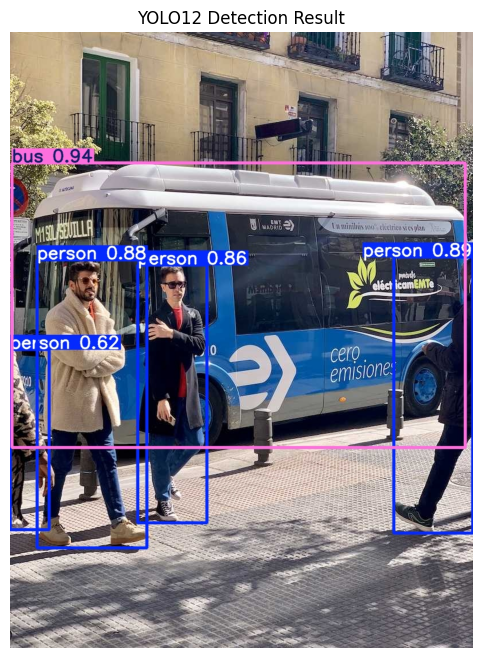

In [12]:
# Visualizar resultado
from PIL import Image
import matplotlib.pyplot as plt

# YOLO guarda resultados en runs/detect/predict
result_image_path = Path("runs/detect/predict/test_image.jpg")
if result_image_path.exists():
    img = Image.open(result_image_path)
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title("YOLO12 Detection Result")
    plt.show()
else:
    print("Result image not found")

## Iniciar MLflow UI (ejecutar en terminal separada)
```bash
mlflow ui --backend-store-uri file:///path/to/product_recognition/mlruns --port 5000
```
Luego acceder a: http://localhost:5000

In [13]:
# Mostrar comando para iniciar MLflow UI
print(f"\n{'='*60}")
print("Para iniciar MLflow UI, ejecuta en terminal:")
print(f"\nmlflow ui --backend-store-uri {mlflow.get_tracking_uri()} --port 5000")
print(f"\nLuego abre: http://localhost:5000")
print(f"{'='*60}")


Para iniciar MLflow UI, ejecuta en terminal:

mlflow ui --backend-store-uri file:////home/siryorch/Documents/aprendizaje/productrecognition/Testing/product_recognition/mlruns --port 5000

Luego abre: http://localhost:5000


## ✅ Setup completado
Siguiente notebook: `02_data_loading_eda.ipynb`